# The Model Review

_improving transparency, reproducibility & knowledge sharing with MLflow_

<center><img src="https://mlflow.org/images/MLflow-logo-final-white-TM.png" style="width: 200px"></center>

Jes Ford, PhD  
ML Engineer at Cash App (Block)

# Hi, Jes Ford here 👋

- Snowboarder 1st 🏂
- PhD in Physics 🔭
- Machine Learning Engineer (Modeler) at Cash App, Block
- Working on Natural Language Understanding for Customer Support
- Originally from Alaska, currently living in Salt Lake City

# About this talk

- Why did my team decide to adopt a process for Model Review?
- What does Model Review mean?
- Our primary tool for review: MLflow
- Intro to MLflow
- How we are using MLflow to solve some of our problems

# Motivation

Our team had recently doubled in size and was deploying lots of models.

But we had no good record keeping on what models exactly were in production, how they were trained, or what tricks or approaches were working well...

# Motivation

What if a model needed to be retrained?

A new team member wants to build off the work that came before them?

What was the precision on that model supposed to be anyway?

## _uhhh, let me see if I can find that notebook..._

# Goals for a new Model Review Process

1. **Transparency** and record keeping of what exactly is being deployed
2. **Reproducibility** of past experiments and ease of building off of them
3. **Knowledge Sharing** so we can learn from each other and new teammembers can get up to speed

ALSO: We need to **automate** as much of this as possible!

# Comparison to Code Review

# Why do we Review _Code_?

- More 👀 on code to spot bugs and potential issues
- Pull Requests create a record of changes/commits and also (ideally) documentation of changes, design decisions, trade-offs, etc.
- Knowledge sharing between teammates

# Code vs Model Review _Similarities_

There is code involved.

# Code vs Model Review _Differences_

- There is a lot of context beyond the Code Used to train a model
  - data, including any transformations
  - performance
  - entire ML process, including all your failed experiments
- We can't really review a model _just_ by reading the final code

---

**BEGIN MLFLOW TUTORIAL SECTION**

---

# What is MLflow?

"Open source platform for managing the end-to-end machine learning lifecycle"

<center><img src="https://databricks.com/wp-content/uploads/2018/06/mlflow.png" style="width: 500px"></center>

Language & library agnostic: includes APIs for Python, R, Java, but everything is accessible throuh a REST API & CLI, so it's very flexible for different use cases.

image source: [databricks blog](https://databricks.com/blog/2018/06/05/introducing-mlflow-an-open-source-machine-learning-platform.html)

### `$ pip install mlflow`

# MLflow Tracking

Easily log almost anything you want to keep track of:
- parameters
- metrics
- arbitrary files ("artifacts" in mlflow)
  - such as plots, output files, Jupyter notebooks...
- code version
- training data

# First Example

In [1]:
import mlflow

mlflow.log_param('my_parameter', 4)  # run starts automatically
mlflow.log_metric('score', 100)
mlflow.end_run()

# Where is this logged?

By default we just log to a local directory:

<center><img src="https://www.mlflow.org/docs/latest/_images/scenario_1.png" style="width: 800px;"></center>

We can _access_ what we've logged using either the MLflow API or the **MLflow Tracking UI**.

image source: [mlflow docs](https://www.mlflow.org/docs)

# MLflow Tracking UI

![img](img/mlflow_ui_command.png)



$\rightarrow$ Go to http://127.0.0.1:5000 in your browser...

![img](img/mlflow_ui_00.png)

![img](img/mlflow_ui_01.png)

# Logging Artifacts

In [2]:
import mlflow

# explicitly start the run to give it a nice name
mlflow.start_run(run_name='log-artifacts')

mlflow.log_param('my_parameter', 3)
mlflow.log_metric('score', 95)

with open('my_artifact.txt', 'w') as f:
    f.write('This is the contents of a file to be logged.')

mlflow.log_artifact('my_artifact.txt')

mlflow.end_run()

![img](img/mlflow_ui_02.png)

![img](img/mlflow_ui_03.png)

# Where MLflow data is stored?

By default your runs are recorded in files in a local `mlruns/` folder in your working directory. Lots of other options for local and remote tracking - see [MLflow docs](https://www.mlflow.org/docs/latest/tracking.html#how-runs-and-artifacts-are-recorded) for possibilities.

<center><table><tr>
  <td><img src="https://www.mlflow.org/docs/latest/_images/scenario_1.png" style="width: 800px;"></td>
  <td><img src="https://www.mlflow.org/docs/latest/_images/scenario_5.png" style="width: 1200px;"></td>
</tr></table></center>

image source: [mlflow docs](https://www.mlflow.org/docs)

# Not just for ML!

Notice that nothing we've done so far has been ML specific!

You could use MLFlow Tracking for kind of any analyses or projects where you find yourself manually recording values.

_(example: at a previous job, people recorded results of model training in a spreadsheet. They had scripts to automate populating this spreadsheet, but it still involved more overhead and was more error prone than MLflow's tracking)_

In [3]:
# suppress all warnings for presentation purposes
import warnings
warnings.simplefilter('ignore')

# ... but let's do some ML

["20 Newsgroups" dataset](http://qwone.com/~jason/20Newsgroups/): text documents containing discussions of 20 different topics.

We'll just use 2 of these topics and build a binary classifier to distinguish between text that is about baseball vs hockey.

## Load & Prepare a Real World Dataset

In [4]:
from sklearn.datasets import fetch_20newsgroups

# load train and test data for 2 categories
categories_to_classify = ['rec.sport.baseball', 'rec.sport.hockey']
X_train_raw, y_train = fetch_20newsgroups(
    subset='train', categories=categories_to_classify, return_X_y=True
)
X_test_raw, y_test = fetch_20newsgroups(
    subset='test', categories=categories_to_classify, return_X_y=True
)

In [5]:
# Example document
print(X_train_raw[0])

From: dougb@comm.mot.com (Doug Bank)
Subject: Re: Info needed for Cleveland tickets
Reply-To: dougb@ecs.comm.mot.com
Organization: Motorola Land Mobile Products Sector
Distribution: usa
Nntp-Posting-Host: 145.1.146.35
Lines: 17

In article <1993Apr1.234031.4950@leland.Stanford.EDU>, bohnert@leland.Stanford.EDU (matthew bohnert) writes:

|> I'm going to be in Cleveland Thursday, April 15 to Sunday, April 18.
|> Does anybody know if the Tribe will be in town on those dates, and
|> if so, who're they playing and if tickets are available?

The tribe will be in town from April 16 to the 19th.
There are ALWAYS tickets available! (Though they are playing Toronto,
and many Toronto fans make the trip to Cleveland as it is easier to
get tickets in Cleveland than in Toronto.  Either way, I seriously
doubt they will sell out until the end of the season.)

-- 
Doug Bank                       Private Systems Division
dougb@ecs.comm.mot.com          Motorola Communications Sector
dougb@nwu.edu       

# Transform data from raw text to numbers

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X_train = vectorizer.fit_transform(X_train_raw).todense()
X_test = vectorizer.transform(X_test_raw).todense()

print('Training set size after TF-IDF transform: {}'.format(X_train.shape))

Training set size after TF-IDF transform: (1197, 100)


# Tracking your ML Model

Use a context manager instead of explicitly starting and ending the run.

In [7]:
import mlflow
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay

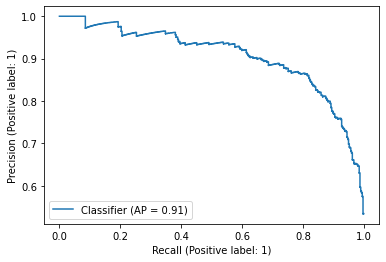

In [8]:
with mlflow.start_run(run_name='hockey-vs-baseball'):

    # fit a model with certain hyperparameters
    penalty = 'l2'
    max_iter = 10
    clf = LogisticRegression(penalty=penalty, max_iter=max_iter)
    clf.fit(X_train, y_train)
    
    # get predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_test_predprob = clf.predict_proba(X_test)[:, 1]

    # make a plot
    fig, ax = plt.subplots(1, 1)
    PrecisionRecallDisplay.from_predictions(y_test, y_test_predprob, ax=ax)
    fig.savefig('PR.png')

    # track all the things
    mlflow.log_params({'penalty': penalty, 'max_iter': max_iter})
    mlflow.log_metric('acc', accuracy_score(y_train, y_train_pred))
    mlflow.log_metric('val_acc', accuracy_score(y_test, y_test_pred))
    mlflow.log_artifact('PR.png')
    mlflow.log_artifact('tutorial.ipynb')
    mlflow.sklearn.log_model(clf, 'model')

![img](img/mlflow_ui_04.png)

![img](img/mlflow_ui_05.png)

### MLflow provides code snippets for loading & using the trained model via the mlflow API

![img](img/mlflow_ui_06.png)

![img](img/mlflow_ui_07.png)

# Autologging Model Training

A single line of code will automatically tracks lots of useful things about your model, metrics, plots.

Supported for `scikit-learn`, `tensorflow` & `keras`, `pytorch`, `xgboost`, and more.

_Note:_ this is an "experimental" feature in MLflow!

# Autologging Example 1: `sklearn`

In [9]:
from sklearn.ensemble import RandomForestClassifier

mlflow.sklearn.autolog()  # just one line added!

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)

2022/04/19 20:37:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/04/19 20:37:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd2049ae6b4074af49867e89e58d9973c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


RandomForestClassifier(n_estimators=10)

# Back in the MLflow UI...

![img](img/mlflow_ui_08.png)

### We see all RF hyperparameters (even those we didn't set explicitly) are recorded...

... as well as some default training metrics (would have to log validation metrics manually since `.fit` doesn't know about them)

... and we get some really useful plots out of the box!

# Autologging Example 2: `tensorflow.keras`

In [16]:
import tensorflow as tf
from tensorflow.keras import Input, Model, layers

# parameters to vary
hidden_layer_size = 32
learning_rate = 0.01

with mlflow.start_run(run_name=f'sports-NN-{hidden_layer_size}d-lr{learning_rate}'):

    mlflow.tensorflow.autolog()  # just one line added!

    # a simple NN with one hidden layer
    inputs = Input(shape=(X_train.shape[1],))
    x = layers.Dense(hidden_layer_size, activation='relu')(inputs)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    loss = 'binary_crossentropy'
    optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
    metrics = [
        tf.metrics.BinaryAccuracy(),
        tf.metrics.AUC(curve='ROC', name='AUROC'),
    ]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    model.fit(X_train, y_train, epochs=40, shuffle=True, validation_data=(X_test, y_test))

Train on 1197 samples, validate on 796 samples
Epoch 1/40
1152/1197 [===========================>..] - ETA: 0s - loss: 0.6944 - binary_accuracy: 0.4826 - AUROC: 0.4870

2022-04-19 20:51:03.144988: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


1197/1197 [==============================] - 2s 2ms/sample - loss: 0.6945 - binary_accuracy: 0.4795 - AUROC: 0.4853 - val_loss: 0.6879 - val_binary_accuracy: 0.5540 - val_AUROC: 0.5841
Epoch 2/40
1197/1197 [==============================] - 0s 252us/sample - loss: 0.6933 - binary_accuracy: 0.4937 - AUROC: 0.5005 - val_loss: 0.6870 - val_binary_accuracy: 0.5666 - val_AUROC: 0.5963
Epoch 3/40
1197/1197 [==============================] - 0s 250us/sample - loss: 0.6920 - binary_accuracy: 0.5104 - AUROC: 0.5184 - val_loss: 0.6861 - val_binary_accuracy: 0.5854 - val_AUROC: 0.6069
Epoch 4/40
1197/1197 [==============================] - 0s 267us/sample - loss: 0.6909 - binary_accuracy: 0.5246 - AUROC: 0.5357 - val_loss: 0.6852 - val_binary_accuracy: 0.5930 - val_AUROC: 0.6176
Epoch 5/40
1197/1197 [==============================] - 0s 246us/sample - loss: 0.6896 - binary_accuracy: 0.5455 - AUROC: 0.5524 - val_loss: 0.6843 - val_binary_accuracy: 0.6055 - val_AUROC: 0.6310
Epoch 6/40
1197/1197 [=

# ... back in MLflow UI

Again, all the parameters & metrics relevant to the run are recorded automatically

![img](img/mlflow_ui_09.png)

### Notice model summary, tensorboard logs, and the TF saved model

Note: our team uses this saved model artifact (the inner model folder) directly for deployment, since our infrastructure isn't yet set up to deploy from MLflow directly.

# Clicking into one of the metrics, we can view training curves

![img](img/mlflow_ui_10.png)

# Powerful features for comparing lots of models

Suppose you had run many iterations of this small NN with different hyperparameters...

## In the UI you can sort by metrics for a Leaderboard

![img](img/mlflow_ui_11.png)

### ... you can also view run details side-by-side

By selecting a few checkboxes and clicking the "Compare" button. Notice parameter differences are highlighted!

## Select a few models to compare

![img](img/mlflow_ui_12.png)

![img](img/mlflow_ui_13.png)

## Click into metrics to compare training curves from different runs

Similar to TensorBoard.

![img](img/mlflow_ui_14.png)

---

**END MLFLOW TUTORIAL SECTION**

---

# Incorporating MLflow into our Model Review Process

# Step 1: Training Infrastructure

Create/maintain a reasonably-flexibly **common training infrastructure** that works for _most_ of our team's problems.

# Step 2: MLflow Tracking

**MLflow Tracking** is embedded in this infrastructure, so experiment record-keeping happens automatically:
- all training parameters & settings
- train and test metrics
- environment: the docker image, code version, the training script or notebook itself
- model (and related artifacts needed for deployment)
- common plots and results of analyses that help us understand performance

# Step 3: Use Notes for Context

**MLflow UI Markdown Notes** section used for all the context that can't be recorded automatically:
- business requirements, e.g. links to any project docs
- things we tried that didn't work
- describe any non-standard treatment of the data
- decisions or trade-offs made along the way
- if shadow deployed, any observations on live data
- anything you'd want to know if you were picking up the project from scratch

# Step 4: Model Review

Prior to Live Launch of a new model, trigger a **Model Review**:
- make sure all "required" fields were tracked and fill out the Notes section
- request a primary and secondary reviewer and send them the link to the MLflow run
- reviewers expected to review the MLflow run & related code async
- schedule a 30min _synchronous_ review, other team members invited as optional
- meeting is to discuss, ask questions, make suggestions (rarely to block deployment)

# Back to our Goals for Model Review

1. **Transparency** is acheived by having shareable links to all the training details.
2. **Reproducibility** is improved by recording everything needed to re-create a training run.
3. **Knowledge Sharing** happens through the review process or simply by sharing MLflow examples with colleagues.

MLflow is a helpful for this because we can view so many details about the model in one place.

# Summary

- We improved model deployment record keeping by integrating MLflow tracking into our shared training infrastructure.
- MLflow is a lightweight and powerful way to track your ML experiments
  - adding one line of code (autologging) can get you a long way!
  - we only talked about Tracking here (see also: MLflow Projects, Models, Model Registry)
- Our review "process" is a WIP! I'd _really_ love to talk to anyone who has different processes in place for things like this!

# Questions? 🤔

This notebook presentation is on GitHub: https://github.com/jesford/model-review

In [1]:
%%html
<style type="text/css">

.reveal p {
    font-size: 80%;
}

.reveal li {
    font-size: 80%;
}

# .reveal li li {
#     font-size: 80%;
# }

.reveal h1 {
    color: #4ec5c7;
    font-size: 48px;
}

.reveal h2 {
    color: #4ec5c7;
    font-size: 36px;
}

.reveal h3 {
    font-size: 30px;
}

# .reveal table {
#     font-size: 1em;
# }

# .reveal div.highlight {
#     margin: 0; 
# }

# .reveal div.highlight>pre {
#     margin: 0; 
#     width: 100%;
#     font-size: var(--jp-code-font-size);
# }

# .reveal div.jp-OutputArea-output>pre {
#     margin: 0; 
#     width: 90%;
#     font-size: var(--jp-code-font-size);
#     box-shadow: none;
# }

</style>

# note: can't set as slide type "skip" or settings aren't applied, use "notes".